In [ ]:
from pathlib import Path
import xml.etree.ElementTree as ET
from shutil import copyfile
import os
import numpy as np
import pandas as pd

In [ ]:
from google.colab import userdata

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [ ]:
!kaggle datasets download -d andrewmvd/hard-hat-detection

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/hard-hat-detection
License(s): CC0-1.0
100% 1.22G/1.22G [00:16<00:00, 155MB/s]
100% 1.22G/1.22G [00:16<00:00, 77.5MB/s]


In [ ]:
!unzip 'hard-hat-detection'

Streaming output truncated to the last 5000 lines.
  inflating: images/hard_hat_workers0.png  
  inflating: images/hard_hat_workers1.png  
  inflating: images/hard_hat_workers10.png  
  inflating: images/hard_hat_workers100.png  
  inflating: images/hard_hat_workers1000.png  
  inflating: images/hard_hat_workers1001.png  
  inflating: images/hard_hat_workers1002.png  
  inflating: images/hard_hat_workers1003.png  
  inflating: images/hard_hat_workers1004.png  
  inflating: images/hard_hat_workers1005.png  
  inflating: images/hard_hat_workers1006.png  
  inflating: images/hard_hat_workers1007.png  
  inflating: images/hard_hat_workers1008.png  
  inflating: images/hard_hat_workers1009.png  
  inflating: images/hard_hat_workers101.png  
  inflating: images/hard_hat_workers1010.png  
  inflating: images/hard_hat_workers1011.png  
  inflating: images/hard_hat_workers1012.png  
  inflating: images/hard_hat_workers1013.png  
  inflating: images/hard_hat_workers1014.png  
  inflating: images

In [ ]:
classes = ['helmet','head', 'person']

def convert_annot(size , box):
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])

    dw = np.float32(1. / int(size[0]))
    dh = np.float32(1. / int(size[1]))

    w = x2 - x1
    h = y2 - y1
    x = x1 + (w / 2)
    y = y1 + (h / 2)

    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return [x, y, w, h]

In [ ]:
import os

def save_txt_file(img_jpg_file_name, size, img_box):
    # Define the directory path
    save_directory = '/content/dataset/labels/'

    # Create the directory if it does not exist
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)

    # Define the full file name with path
    save_file_name = save_directory + img_jpg_file_name + '.txt'

    with open(save_file_name, 'a+') as file_path:
        for box in img_box:
            cls_num = classes.index(box[0])

            # Assuming convert_annot is a function that processes the box annotations
            new_box = convert_annot(size, box[1:])

            file_path.write(f"{cls_num} {new_box[0]} {new_box[1]} {new_box[2]} {new_box[3]}\n")

        file_path.flush()  # Flush any remaining data in the buffer

In [ ]:
def get_xml_data(file_path, img_xml_file):
    img_path = file_path + '/' + img_xml_file + '.xml'

    tree = ET.parse(img_path)
    root = tree.getroot()

    img_name = root.find("filename").text
    img_size = root.find("size")
    img_w = int(img_size.find("width").text)
    img_h = int(img_size.find("height").text)
    img_c = int(img_size.find("depth").text)

    img_box = []
    for box in root.findall("object"):
        cls_name = box.find("name").text
        x1 = int(box.find("bndbox").find("xmin").text)
        y1 = int(box.find("bndbox").find("ymin").text)
        x2 = int(box.find("bndbox").find("xmax").text)
        y2 = int(box.find("bndbox").find("ymax").text)

        img_box.append([cls_name, x1, y1, x2, y2])

    img_jpg_file_name = img_xml_file + '.jpg'
    save_txt_file(img_xml_file, [img_w, img_h], img_box)

In [ ]:
from tqdm import tqdm

files = os.listdir('/content/annotations')
for file in tqdm(files, total=len(files)):
    file_xml = file.split(".")
    get_xml_data('/content/annotations', file_xml[0])

100%|██████████| 5000/5000 [00:03<00:00, 1500.74it/s]


In [ ]:
from sklearn.model_selection import train_test_split

image_list = os.listdir('/content/annotations')
train_list, test_list = train_test_split(image_list, test_size=0.2, random_state=42)
val_list, test_list = train_test_split(test_list, test_size=0.5, random_state=42)
print('total =', len(image_list))
print('train :', len(train_list))
print('val   :', len(val_list))
print('test  :', len(test_list))

total = 5000
train : 4000
val   : 500
test  : 500


In [ ]:
from pathlib import Path
from shutil import copyfile
from tqdm import tqdm

def copy_data(file_list, img_labels_root, imgs_source, mode):
    dataset_root = Path('/content/images')

    # Create directories if they don't exist
    images_path = dataset_root / 'images' / mode
    labels_path = dataset_root / 'labels' / mode
    images_path.mkdir(parents=True, exist_ok=True)
    labels_path.mkdir(parents=True, exist_ok=True)

    # Copying files with progress bar
    for file in tqdm(file_list, desc=f"Copying {mode} data"):
        base_filename = file.split('.')[0]

        img_src_file = Path(imgs_source) / (base_filename + '.png')
        label_src_file = Path(img_labels_root) / (base_filename + '.txt')

        img_dest_file = images_path / (base_filename + '.png')
        label_dest_file = labels_path / (base_filename + '.txt')

        copyfile(img_src_file, img_dest_file)
        copyfile(label_src_file, label_dest_file)

# Example usage
copy_data(train_list, '/content/dataset/labels', '/content/images', "train")
copy_data(val_list,   '/content/dataset/labels', '/content/images', "val")
copy_data(test_list,  '/content/dataset/labels', '/content/images', "test")

Copying test data: 100%|██████████| 500/500 [00:00<00:00, 1092.49it/s]


In [ ]:
!git clone https://github.com/ultralytics/ultralytics
!pip install ultralytics

In [ ]:
import yaml

# Create configuration
config = {

   "train": "/content/images/images/train",
   "val": "/content/images/images/val",
   "test": "/content/images/images/test",
   "nc": 3,
   "names": ['helmet','head','person']
}
with open("data.yaml", "w") as file:
   yaml.dump(config, file, default_flow_style=False)

In [ ]:
!cat data.yaml

names:
- helmet
- head
- person
nc: 3
test: /content/images/images/test
train: /content/images/images/train
val: /content/images/images/val


In [ ]:
!yolo task=detect mode=train data=data.yaml model=yolov8m.pt epochs=20 lr0=0.01

In [ ]:
!yolo task=detect mode=val model=/content/best.pt conf=0.25 source="/content/test" save_txt=True save=True

In [ ]:
!yolo task=detect mode=val model=/content/best.pt data=data.yaml split='test' save_json= True

In [ ]:
import shutil
from google.colab import files

# Membuat file zip dari folder yang ingin di-download
shutil.make_archive('/content/runs', 'zip', '/content/runs')

# Download file zip tersebut
files.download('/content/runs.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import cv2
from google.colab.patches import cv2_imshow  # Import untuk menampilkan gambar di Colab
from ultralytics import YOLO


# Inisialisasi model YOLOv8 dengan file model yang sudah dilatih
model = YOLO('/content/best.pt')

# Definisikan classes yang digunakan oleh model (sesuai dengan dataset)
classes = ['with helmet', 'no helmet', 'person']

# Fungsi untuk melakukan deteksi dan menampilkan bounding box dan label
def detect_objects(image):
    # Lakukan prediksi pada gambar yang diinput
    results = model(image)

    # Ambil bounding box, confidence score, dan label prediksi
    for result in results[0].boxes:
        bbox = result.xyxy[0].cpu().numpy()  # Bounding box koordinat
        class_id = int(result.cls[0])  # ID class
        confidence = result.conf[0].cpu().numpy()  # Confidence score

        # Gambar bounding box di gambar asli
        cv2.rectangle(image,
                      (int(bbox[0]), int(bbox[1])),
                      (int(bbox[2]), int(bbox[3])),
                      (0, 255, 0), 2)

        # Tampilkan label class dan confidence di atas bounding box
        label = f"{classes[class_id]}: {confidence:.2f}"
        cv2.putText(image, label,
                    (int(bbox[0]), int(bbox[1]) - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, (0, 255, 0), 2)

    # Tampilkan gambar hasil deteksi di Colab
    cv2_imshow(image)



0: 448x640 1 helmet, 1 head, 980.3ms
Speed: 6.5ms preprocess, 980.3ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)


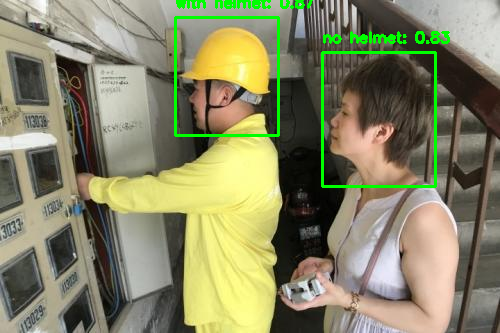

In [ ]:

# Fungsi untuk membaca gambar atau video input
def process_input(input_path):
    # Cek apakah input berupa video atau gambar
    if input_path.endswith(('.mp4', '.avi', '.mov')):
        # Jika input berupa video
        cap = cv2.VideoCapture(input_path)

        # Baca frame per frame dari video
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Deteksi objek di frame video
            detect_objects(frame)

            # Tampilkan frame hasil deteksi
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        # Lepaskan resource video setelah selesai
        cap.release()
    else:
        # Jika input berupa gambar
        image = cv2.imread(input_path)

        # Deteksi objek di gambar
        detect_objects(image)

        # Tunggu sampai pengguna menekan tombol untuk menutup jendela
        cv2.waitKey(0)

    # Tutup semua jendela OpenCV setelah selesai
    cv2.destroyAllWindows()

# Input file (bisa berupa video atau foto)
input_path = '/content/foto1.jpg'  # Ubah sesuai dengan path video atau gambar Anda
process_input(input_path)

In [ ]:
!kaggle datasets download -d ayushraj2349/sample-videos-for-helmet-detection-on-yolov8

Dataset URL: https://www.kaggle.com/datasets/ayushraj2349/sample-videos-for-helmet-detection-on-yolov8
License(s): MIT
 47% 5.00M/10.6M [00:00<00:00, 45.4MB/s]
100% 10.6M/10.6M [00:00<00:00, 82.2MB/s]


In [ ]:
!unzip '/content/sample-videos-for-helmet-detection-on-yolov8.zip'

Archive:  /content/sample-videos-for-helmet-detection-on-yolov8.zip
  inflating: videos_infer/1.mp4      
  inflating: videos_infer/2.mp4      
  inflating: videos_infer/20sec.mp4  
  inflating: videos_infer/3.mp4      
  inflating: videos_infer/30sec.mp4  


In [ ]:
# Mengakses kamera dan melakukan deteksi objek secara realtime
def detect_from_camera():
    # Buka kamera (0 berarti kamera default)
    cap = cv2.VideoCapture(0)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Deteksi objek di frame kamera
        detected_frame = detect_objects(frame)

        # Tampilkan frame hasil deteksi
        cv2.imshow('Helmet Detection', detected_frame)

        # Tekan 'q' untuk keluar dari loop
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Lepaskan kamera dan tutup jendela
    cap.release()
    cv2.destroyAllWindows()

# Jalankan deteksi dari kamera
detect_from_camera()

## COBA VIDEO

In [ ]:
import cv2
from ultralytics import YOLO

# Inisialisasi model YOLOv8 dengan file model yang sudah dilatih
model = YOLO('best.pt')

# Fungsi untuk melakukan deteksi dan menampilkan bounding box dan label
def detect_objects(image):
    # Lakukan prediksi pada gambar yang diinput
    results = model(image)

    # Ambil bounding box, confidence score, dan label prediksi
    for result in results[0].boxes:
        bbox = result.xyxy[0].cpu().numpy()  # Bounding box koordinat
        class_id = int(result.cls[0])  # ID class
        confidence = result.conf[0].cpu().numpy()  # Confidence score

        # Gambar bounding box di gambar asli
        cv2.rectangle(image,
                      (int(bbox[0]), int(bbox[1])),
                      (int(bbox[2]), int(bbox[3])),
                      (0, 255, 0), 2)

        # Tampilkan label class dan confidence di atas bounding box
        label = f"{classes[class_id]}: {confidence:.2f}"
        cv2.putText(image, label,
                    (int(bbox[0]), int(bbox[1]) - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, (0, 255, 0), 2)

    return image

# Fungsi untuk mendeteksi objek dari video yang diunggah
def process_video(video_path, output_path):
    cap = cv2.VideoCapture(video_path)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, 20.0, (640, 480))

    # Membaca frame per frame dari video
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Deteksi objek di frame video
        detected_frame = detect_objects(frame)

        # Simpan frame hasil deteksi
        out.write(detected_frame)

    # Lepaskan resource video
    cap.release()
    out.release()

# Jalankan deteksi objek pada video
video_path = '/content/videos_infer/1.mp4'  # Path video input
output_path = '/content/output_video.mp4'  # Path output video hasil deteksi

process_video(video_path, output_path)



0: 384x640 3 helmets, 1214.7ms
Speed: 13.4ms preprocess, 1214.7ms inference, 3.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 helmets, 1203.2ms
Speed: 2.9ms preprocess, 1203.2ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 helmets, 1017.9ms
Speed: 2.0ms preprocess, 1017.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 helmets, 706.5ms
Speed: 2.4ms preprocess, 706.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 helmets, 726.3ms
Speed: 2.9ms preprocess, 726.3ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 helmets, 711.1ms
Speed: 2.2ms preprocess, 711.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 helmets, 709.5ms
Speed: 2.5ms preprocess, 709.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 3 helmets, 721.4ms
Speed: 2.0ms preprocess, 721.4ms inference, 0.9ms postproce

In [ ]:
from IPython.display import HTML
from base64 import b64encode

def show_video(video_path, video_width=600):
    # Membaca file video sebagai binary
    video_file = open(video_path, "rb").read()
    # Encode file video dalam base64
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    # Kode HTML untuk memutar video
    return HTML(f"""<video width={video_width} controls>
                        <source src="{video_url}" type="video/mp4">
                    </video>""")

# Tampilkan video hasil deteksi objek
show_video('/content/output_video.mp4')


In [ ]:
import shutil
from google.colab import files

# Membuat file zip dari folder yang ingin di-download
shutil.make_archive('/content/runs', 'zip', '/content/runs')

# Download file zip tersebut
files.download('/content/runs.zip')

In [ ]:
model.export(format='saved_model')

In [ ]:
import shutil
from google.colab import files

shutil.make_archive('/content/best_saved_model', 'zip', '/content/best_saved_model')

# Download file zip
files.download('/content/best_saved_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Download video
files.download('/content/output_video.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>